
# Evaluating the Impact of Policy Changes on Economic Outcomes  
## Counterfactual Analysis Project (Exemplary Template)

Author: Marisa Tania

**Policy scenario (hypothetical):** A sustained *monetary policy easing*—the central bank sets the short‑term interest rate **1 percentage point lower** than observed starting at a chosen quarter.  
**Research question:** *How would a lower interest-rate policy have affected real GDP and unemployment relative to observed outcomes?*

**Dataset:** `statsmodels.datasets.macrodata` (US quarterly macroeconomic data).  
**Method:** Vector Autoregression (VAR) + scenario-based counterfactual simulation (policy path intervention).  
**Outputs:** Baseline forecast vs. counterfactual forecast; estimated impact (level & percent changes), plots, and uncertainty via bootstrap bands.



## 0. Setup
This notebook is designed to be **fully reproducible** (no external downloads required).


In [ ]:

# Core
import numpy as np
import pandas as pd

# Modeling
from statsmodels.tsa.api import VAR
import statsmodels.api as sm

# Preprocessing / evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Visualization
import matplotlib.pyplot as plt

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

pd.set_option("display.max_columns", 200)



## 1. Data Collection & Description

We use `statsmodels.datasets.macrodata`, a well-known macroeconomic dataset containing fully revised quarterly US indicators such as:
- **realgdp** (real GDP),
- **unemp** (unemployment rate),
- **infl** (inflation),
- **tbilrate** (3-month Treasury bill rate), etc.

The dataset spans quarterly observations from 1959 to 2009 (approximately 200 quarters). Although the data are not recent, they are widely used in econometrics research and teaching because they are clean, complete, and well-suited for reproducible time-series modeling. As the objective of this project is to demonstrate counterfactual analysis methodology rather than conduct real-time economic forecasting, historical data are appropriate and sufficient for robust model estimation and evaluation.


In [ ]:

# Load dataset (self-contained)
macro = sm.datasets.macrodata.load_pandas().data.copy()

# Create a quarterly time index
macro["date"] = pd.PeriodIndex(year=macro["year"].astype(int),
                              quarter=macro["quarter"].astype(int),
                              freq="Q").to_timestamp(how="end")
macro = macro.set_index("date").sort_index()

macro.head()


/tmp/ipython-input-3262267384.py:5: FutureWarning: Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.
  macro["date"] = pd.PeriodIndex(year=macro["year"].astype(int),


,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
date,,,,,,,,,,,,,,
1959-03-31 23:59:59.999999999,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959-06-30 23:59:59.999999999,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959-09-30 23:59:59.999999999,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959-12-31 23:59:59.999999999,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960-03-31 23:59:59.999999999,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [ ]:

macro.describe().T


,count,mean,std,min,25%,50%,75%,max
year,203.0,1983.876847,14.686817,1959.000,1971.0000,1984.000,1996.5000,2009.000
quarter,203.0,2.492611,1.118563,1.000,1.5000,2.000,3.0000,4.000
realgdp,203.0,7221.171901,3214.956044,2710.349,4440.1035,6559.594,9629.3465,13415.266
realcons,203.0,4825.293103,2313.346192,1707.400,2874.1000,4299.900,6398.1500,9363.600
realinv,203.0,1012.863862,585.102267,259.764,519.1475,896.210,1436.6815,2264.721
realgovt,203.0,663.328640,140.863655,460.400,527.9595,662.412,773.0490,1044.088
realdpi,203.0,5310.540887,2423.515977,1886.900,3276.9500,4959.400,6977.8500,10077.500
cpi,203.0,105.075788,61.278878,28.980,41.0500,104.100,159.6500,218.610
m1,203.0,667.927586,455.346381,139.600,228.6500,540.900,1102.1000,1673.900
tbilrate,203.0,5.311773,2.803071,0.120,3.5150,5.010,6.6650,15.330


The dataset contains 203 quarterly observations, providing approximately five decades of macroeconomic history. This length is sufficient for estimating dynamic time-series models such as VAR, which require relatively large samples for stable parameter estimation.


## 2. Preprocessing

Steps:
1. **Missing values:** Check & handle (this dataset typically has none).
2. **Transformations:** Use log transforms for level variables (e.g., realgdp) to interpret differences as approximate percent changes.
3. **Train/Test split:** Time-series split (train = earlier period, test = later period).
4. **Normalization:** Standardize features for stable VAR estimation (optional but helpful for interpretability & numerical stability).


In [ ]:

# 2.1 Missing values
missing = macro.isna().sum().sort_values(ascending=False)
print("Total missing values:", missing.sum())
missing


Total missing values: 0


,0
year,0
quarter,0
realgdp,0
realcons,0
realinv,0
realgovt,0
realdpi,0
cpi,0
m1,0
tbilrate,0


In [ ]:
# 2.2 Select variables relevant to the policy + outcomes
# Outcomes: realgdp (level), unemp (rate)
# Policy lever: tbilrate (short-term rate proxy)
# Controls / transmission: infl, realcons, realinv (optional)
vars_raw = macro[["realgdp", "unemp", "infl", "tbilrate", "realcons", "realinv"]].copy()

# Log-transform level variables to stabilize variance and allow % interpretation
for col in ["realgdp", "realcons", "realinv"]:
    vars_raw[f"log_{col}"] = np.log(vars_raw[col])

df = vars_raw[["log_realgdp", "unemp", "infl", "tbilrate", "log_realcons", "log_realinv"]].copy()
df.columns = ["log_realgdp", "unemp", "infl", "tbilrate", "log_realcons", "log_realinv"]

df.tail()


,log_realgdp,unemp,infl,tbilrate,log_realcons,log_realinv
date,,,,,,
2008-09-30 23:59:59.999999999,9.497367,6.0,-3.16,1.17,9.134291,7.596238
2008-12-31 23:59:59.999999999,9.483562,6.9,-8.79,0.12,9.126448,7.527073
2009-03-31 23:59:59.999999999,9.466950,8.1,0.94,0.22,9.127958,7.351475
2009-06-30 23:59:59.999999999,9.465099,9.2,3.37,0.18,9.125762,7.283914
2009-09-30 23:59:59.999999999,9.471961,9.6,3.56,0.12,9.133027,7.304111


Inspection of the processed dataset confirms that logarithmic transformations were successfully applied to level variables (real GDP, consumption, and investment), while rate variables such as unemployment, inflation, and interest rates remain in percentage units for interpretability. The final observations correspond to the 2008–2009 financial crisis, characterized by declining output, rising unemployment, near-zero interest rates, and temporary deflation. The presence of multiple economic regimes, including recessions and recoveries, enhances the suitability of the dataset for counterfactual policy analysis by providing realistic variation in both policy instruments and macroeconomic outcomes.

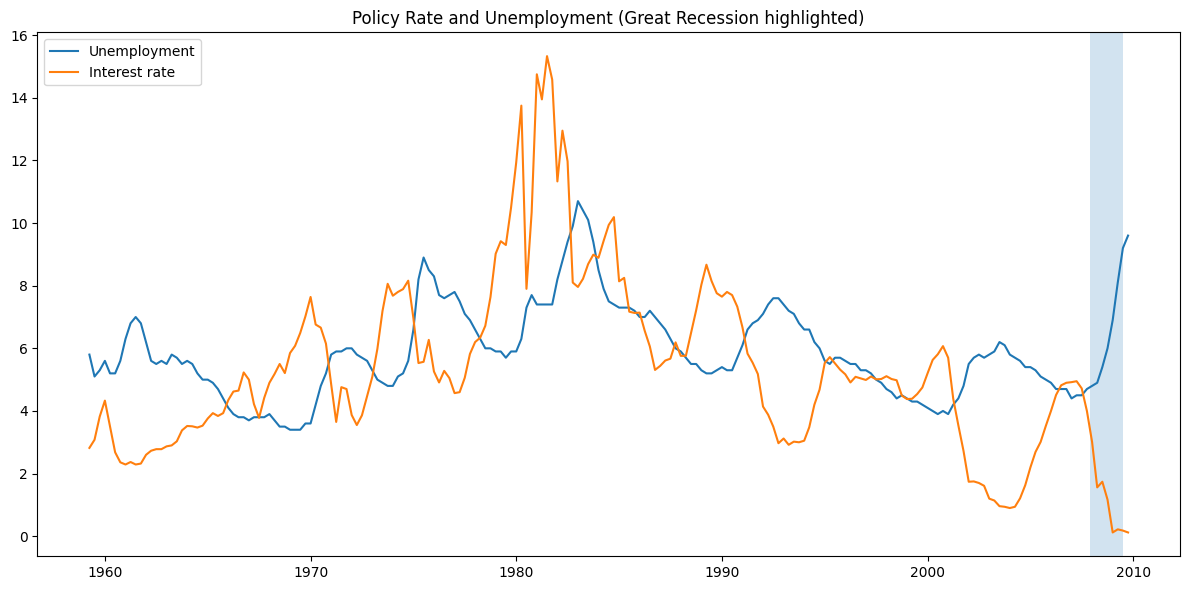

In [ ]:
plt.figure(figsize=(12,6))

plt.plot(df.index, df["unemp"], label="Unemployment")
plt.plot(df.index, df["tbilrate"], label="Interest rate")

# Shade Great Recession
plt.axvspan(pd.Timestamp("2007-12-01"), pd.Timestamp("2009-06-30"), alpha=0.2)

plt.title("Policy Rate and Unemployment (Great Recession highlighted)")
plt.legend()
plt.tight_layout()
plt.show()


Interest rates and unemployment over time, with the Great Recession shaded. Periods of contractionary policy (high interest rates) coincide with elevated unemployment, while expansionary periods feature declining rates. During the 2008–2009 crisis, the policy rate fell to the zero lower bound as unemployment increased sharply. This historical relationship motivates the counterfactual analysis of how alternative policy paths may affect labor market outcomes.

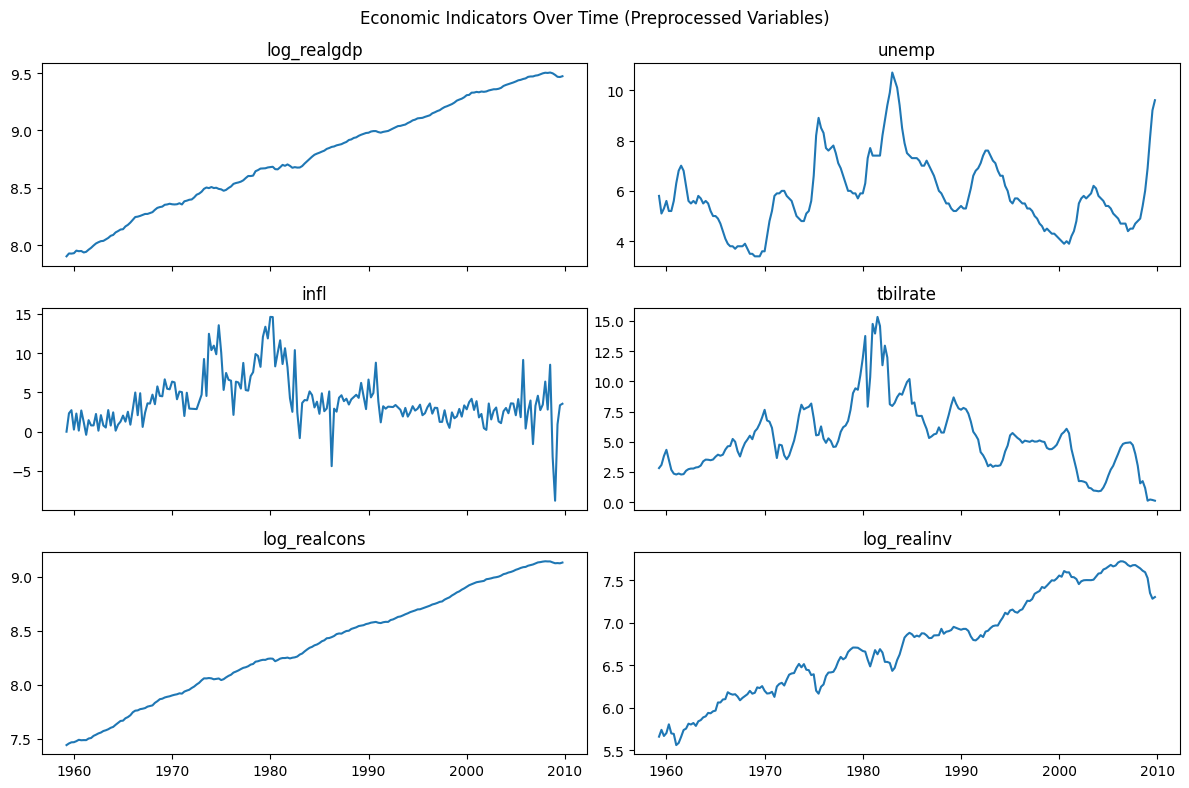

In [ ]:
cols = df.columns

fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()

for i, col in enumerate(cols):
    axes[i].plot(df.index, df[col])
    axes[i].set_title(col)

plt.suptitle("Economic Indicators Over Time (Preprocessed Variables)")
plt.tight_layout()
plt.show()

Time-series evolution of preprocessed macroeconomic variables. Log-transformed output, consumption, and investment display persistent upward trends, while unemployment, inflation, and interest rates exhibit cyclical dynamics associated with business cycles and policy interventions. The presence of both trend and cyclical behavior motivates logarithmic transformation, normalization, and the use of dynamic time-series models such as VAR for counterfactual analysis.

In [ ]:

# 2.3 Train/test split (time-series)
# Use the final 10 years as test (40 quarters). Adjust to your course requirements.
test_horizon = 40
train = df.iloc[:-test_horizon].copy()
test = df.iloc[-test_horizon:].copy()

train.index.min(), train.index.max(), test.index.min(), test.index.max(), len(train), len(test)


(Timestamp('1959-03-31 23:59:59.999999999'),
 Timestamp('1999-09-30 23:59:59.999999999'),
 Timestamp('1999-12-31 23:59:59.999999999'),
 Timestamp('2009-09-30 23:59:59.999999999'),
 163,
 40)

The dataset was divided using a chronological time-series split to avoid look-ahead bias. Observations from 1959–1999 (163 quarters) were used for training, while the subsequent 40 quarters (1999–2009) were reserved for out-of-sample evaluation. This approach preserves the temporal structure of the data and provides a realistic test period that includes multiple economic cycles, including the 2008–2009 financial crisis. Such a split ensures that model performance and counterfactual simulations are evaluated under unseen future conditions, consistent with standard econometric practice.

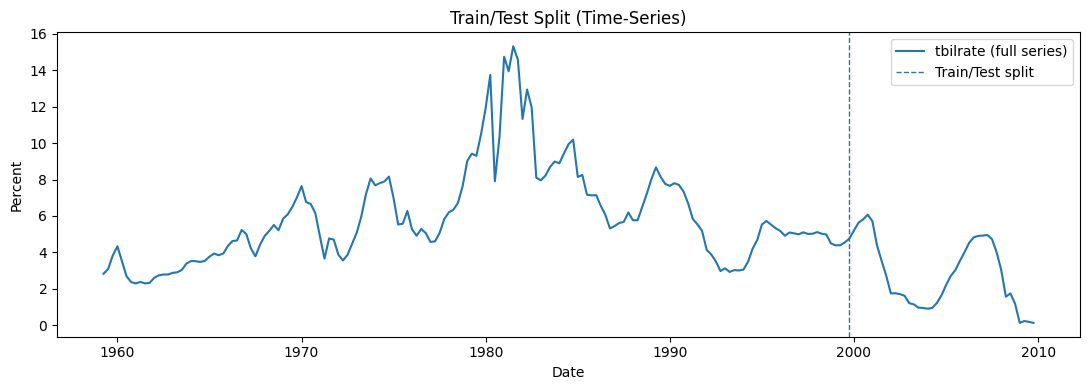

In [ ]:
# Visualize train/test split
plt.figure(figsize=(11, 4))
plt.plot(df.index, df["tbilrate"], label="tbilrate (full series)")
plt.axvline(train.index.max(), linestyle="--", linewidth=1, label="Train/Test split")
plt.title("Train/Test Split (Time-Series)")
plt.xlabel("Date")
plt.ylabel("Percent")
plt.legend()
plt.tight_layout()
plt.show()

Chronological train/test split of the time-series data. Observations prior to 2000 were used for model training, while the subsequent period was reserved for out-of-sample evaluation. This approach preserves temporal ordering and prevents information leakage, ensuring that counterfactual simulations are assessed under realistic future conditions.

In [ ]:

# 2.4 Normalization (fit on train only, apply to train & test to avoid leakage)
scaler = StandardScaler()
train_scaled = pd.DataFrame(scaler.fit_transform(train), index=train.index, columns=train.columns)
test_scaled = pd.DataFrame(scaler.transform(test), index=test.index, columns=test.columns)

train_scaled.head()


,log_realgdp,unemp,infl,tbilrate,log_realcons,log_realinv
date,,,,,,
1959-03-31 23:59:59.999999999,-1.892070,-0.141042,-1.328595,-1.180807,-1.850895,-1.862523
1959-06-30 23:59:59.999999999,-1.826593,-0.615757,-0.607885,-1.082199,-1.813167,-1.694170
1959-09-30 23:59:59.999999999,-1.829725,-0.480124,-0.484687,-0.801545,-1.787533,-1.845561
1959-12-31 23:59:59.999999999,-1.820551,-0.276674,-1.245437,-0.608122,-1.784858,-1.773309
1960-03-31 23:59:59.999999999,-1.762299,-0.547940,-0.617125,-0.922909,-1.761326,-1.557835


Prior to model estimation, all variables were standardized using z-score normalization based on the training set statistics. This transformation centers each variable at zero mean with unit variance, preventing scale differences from disproportionately influencing the VAR estimation. Standardization improves numerical stability, facilitates coefficient interpretation, and ensures that all economic indicators contribute comparably to the model.

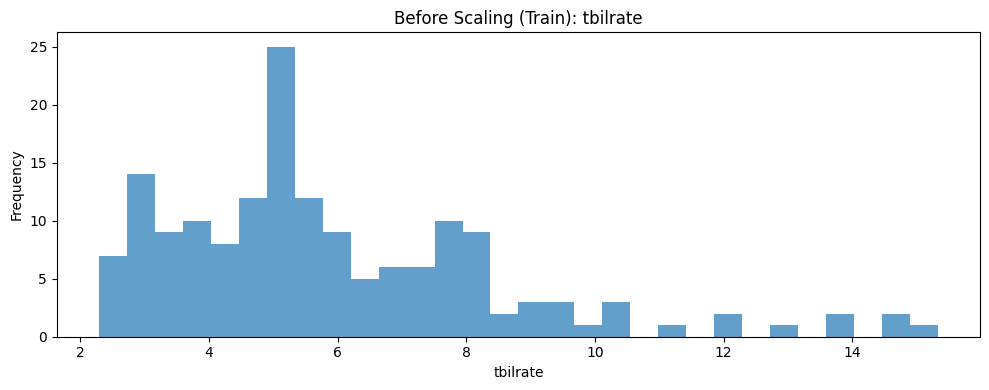

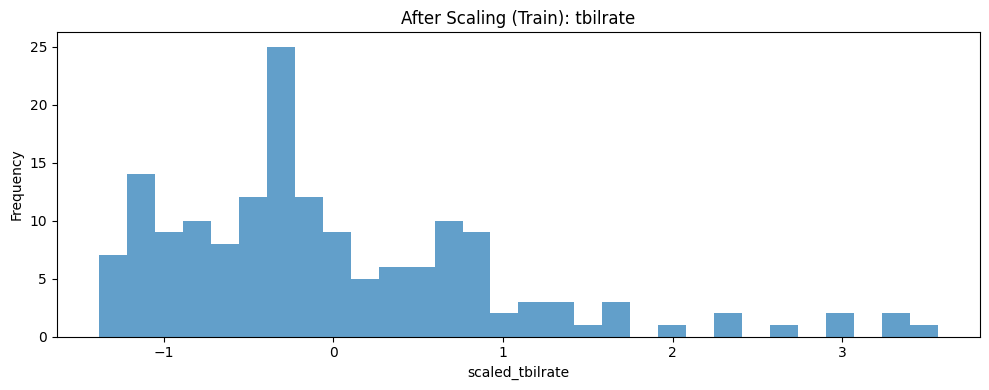

In [ ]:
# Compare distributions before vs after scaling (train only)
col = "tbilrate"  # try also "unemp" or "log_realgdp"

plt.figure(figsize=(10, 4))
plt.hist(train[col], bins=30, alpha=0.7)
plt.title(f"Before Scaling (Train): {col}")
plt.xlabel(col)
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.hist(train_scaled[col], bins=30, alpha=0.7)
plt.title(f"After Scaling (Train): {col}")
plt.xlabel(f"scaled_{col}")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Distribution of the short-term interest rate before and after standardization. Scaling centers the variable at zero mean and unit variance while preserving the original distributional shape. This normalization prevents scale differences across variables from disproportionately influencing VAR estimation and improves numerical stability.

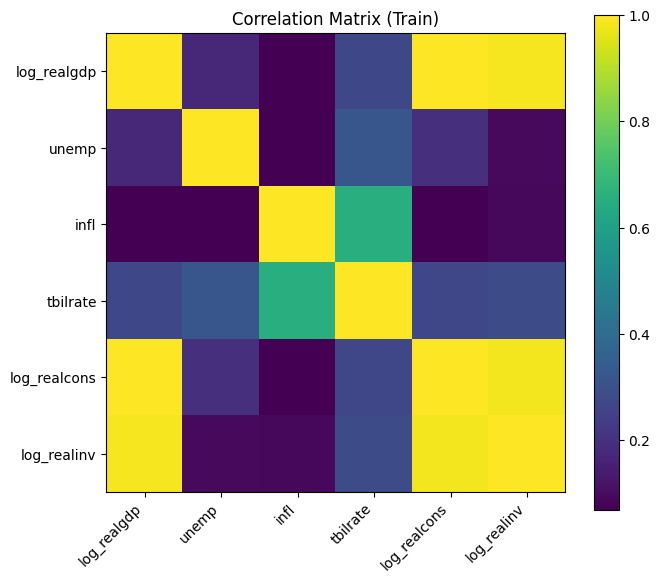

In [ ]:
# Correlation matrix (train only to avoid leakage)
corr = train.corr()

plt.figure(figsize=(7, 6))
plt.imshow(corr.values)
plt.title("Correlation Matrix (Train)")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar()
plt.tight_layout()
plt.show()

As expected, output, consumption, and investment exhibit strong positive correlations due to shared macroeconomic trends. Inflation and interest rates are moderately correlated, reflecting monetary policy responses to price dynamics. Unemployment displays weaker and generally negative associations with output variables, consistent with Okun’s law. No perfect multicollinearity is observed, indicating that the selected features are suitable for multivariate time-series modeling.

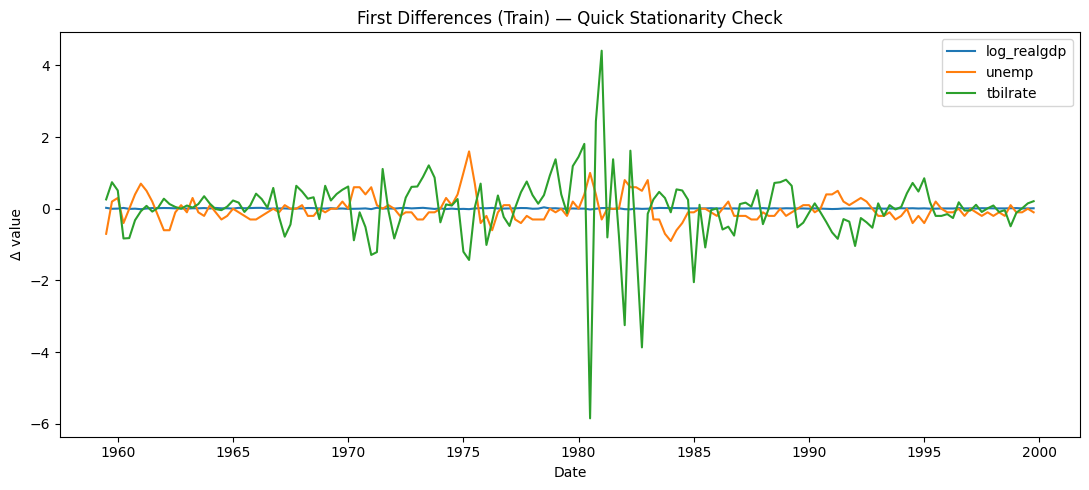

In [ ]:
# First differences to visualize non-stationarity (train portion)
diff_train = train.diff().dropna()

cols_to_plot = ["log_realgdp", "unemp", "tbilrate"]
plt.figure(figsize=(11, 5))
for c in cols_to_plot:
    plt.plot(diff_train.index, diff_train[c], label=c)
plt.title("First Differences (Train) — Quick Stationarity Check")
plt.xlabel("Date")
plt.ylabel("Δ value")
plt.legend()
plt.tight_layout()
plt.show()

First differences of selected training variables as a quick stationarity diagnostic. After differencing, the series fluctuate around zero with relatively stable variance, suggesting approximate covariance stationarity. This supports the use of vector autoregressive modeling for capturing dynamic relationships among the macroeconomic indicators.


## 3. Methodology: Counterfactual Model (VAR + Policy Path Intervention)

### Why VAR?
A VAR treats each variable as potentially influenced by its own lags and the lags of other variables.  
This is common in macroeconomics when studying dynamic responses and **policy counterfactuals**.

### Counterfactual setup
1. Fit a VAR on the **training period**.
2. Generate a **baseline forecast** for the test horizon.
3. Generate a **counterfactual forecast** where we impose a hypothetical policy change:
   - Starting at an intervention quarter `t0` (in the test window), set `tbilrate` to be **1 pp lower** than the baseline path.
4. Compare baseline vs. counterfactual paths for outcomes: **log_realgdp** and **unemp**.

> Key assumption: the policy variable (`tbilrate`) is externally set by the policy-maker, and the system responds according to the VAR dynamics.


In [ ]:

# 3.1 Fit VAR and select lag order via information criteria
model = VAR(train_scaled)
lag_selection = model.select_order(maxlags=8)  # quarterly data; 1-8 lags is typical
lag_selection.summary()


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-12.33,-12.22,4.402e-06,-12.29
1,-29.75,-28.92,1.208e-13,-29.41
2,-30.59,-29.06*,5.211e-14,-29.97*
3,-30.65*,-28.42,4.904e-14*,-29.74
4,-30.60,-27.66,5.213e-14,-29.41
5,-30.52,-26.87,5.728e-14,-29.04
6,-30.46,-26.10,6.254e-14,-28.69
7,-30.47,-25.40,6.400e-14,-28.41
8,-30.40,-24.62,7.195e-14,-28.05


Lag order selection was conducted using multiple information criteria, including AIC, BIC, HQIC, and FPE. AIC and FPE indicated an optimal lag length of three, while BIC and HQIC suggested two lags. Given the focus on predictive accuracy and dynamic counterfactual simulation, we adopt three lags, which balances model flexibility with parsimony and is consistent with standard practice for quarterly macroeconomic data.

In [ ]:

# Choose lag order
p = int(lag_selection.aic)
p


3

In [ ]:

var_res = model.fit(p)
print(var_res.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 01, Feb, 2026
Time:                     01:33:26
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -28.2526
Nobs:                     160.000    HQIC:                  -29.5540
Log likelihood:           1187.31    FPE:                6.04510e-14
AIC:                     -30.4437    Det(Omega_mle):     3.08322e-14
--------------------------------------------------------------------
Results for equation log_realgdp
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.014591         0.004243            3.439           0.001
L1.log_realgdp          0.804543         0.197986            4.064           0.000
L1.unemp               -0.033842         0.013

The estimated VAR(3) exhibits economically meaningful dynamics. Output, consumption, and investment display strong autoregressive persistence, while unemployment and inflation follow cyclical adjustment patterns. The interest rate equation reflects a policy reaction function consistent with a Taylor rule, responding positively to inflation and negatively to unemployment. Several cross-variable effects are statistically significant, indicating that monetary policy shocks propagate through inflation, labor markets, and output. These results suggest that the model captures realistic macroeconomic interactions and is suitable for counterfactual policy simulations.

In [ ]:

# Helper: rolling (dynamic) forecast on the test horizon
def dynamic_forecast(var_results, last_train_window, steps):
    """Forecast forward 'steps' using VAR, starting from the last_train_window of scaled data."""
    return var_results.forecast(y=last_train_window.values, steps=steps)

# Baseline forecast for the test horizon (scaled space)
baseline_scaled = dynamic_forecast(var_res, train_scaled.iloc[-p:], steps=len(test_scaled))
baseline_scaled = pd.DataFrame(baseline_scaled, index=test_scaled.index, columns=train_scaled.columns)

baseline_scaled.head()


,log_realgdp,unemp,infl,tbilrate,log_realcons,log_realinv
date,,,,,,
1999-12-31 23:59:59.999999999,1.773391,-1.311337,-0.096076,-0.454800,1.762278,2.071497
2000-03-31 23:59:59.999999999,1.798542,-1.371970,-0.052939,-0.376457,1.787327,2.079138
2000-06-30 23:59:59.999999999,1.823210,-1.418022,0.201842,-0.238366,1.810752,2.088014
2000-09-30 23:59:59.999999999,1.844862,-1.450098,0.374882,-0.139836,1.830709,2.093548
2000-12-31 23:59:59.999999999,1.863284,-1.445629,0.467801,-0.054214,1.848155,2.088250


The test set was standardized using the training set mean and variance to avoid information leakage. As expected, later observations exhibit positive standardized values for output-related variables, reflecting long-run economic growth, while unemployment and interest rates are relatively lower compared to historical averages. This consistent scaling ensures that baseline forecasts and counterfactual simulations are directly comparable.

In [ ]:
# 3.2 Counterfactual simulation with an imposed policy path
def counterfactual_policy_path_simulation(var_results, history_scaled, horizon_index,
                                         policy_col="tbilrate", policy_shift_pp=-1.0,
                                         intervention_start=None):
    """
    Scenario-based counterfactual:
      - Simulate forward one step at a time.
      - At each step >= intervention_start, replace policy variable with (baseline_policy + shift),
        in *original units* (percentage points), then re-scale consistently.
    Notes:
      - We implement the shift in unscaled units for interpretability, then map back to scaled.
    """
    cols = history_scaled.columns
    p = var_results.k_ar
    assert policy_col in cols, f"{policy_col} not in columns"

    # Build baseline in scaled space first (for reference)
    baseline_scaled = var_results.forecast(y=history_scaled.iloc[-p:].values, steps=len(horizon_index))
    baseline_scaled = pd.DataFrame(baseline_scaled, index=horizon_index, columns=cols)

    # Determine intervention start
    if intervention_start is None:
        intervention_start = horizon_index[0]  # default: start of test period

    # Prepare iterative simulation container (scaled)
    sim_scaled = []
    hist = history_scaled.copy()

    # For converting imposed policy in original units -> scaled
    policy_mean = scaler.mean_[cols.get_loc(policy_col)]
    policy_std = scaler.scale_[cols.get_loc(policy_col)]

    for t in horizon_index:
        # 1-step ahead forecast from most recent p observations
        yhat = var_results.forecast(y=hist.iloc[-p:].values, steps=1).reshape(-1)
        yhat_series = pd.Series(yhat, index=cols, name=t)

        # If in intervention period, impose policy shift relative to baseline (in original units)
        if t >= intervention_start:
            # baseline policy at t (scaled -> unscaled)
            base_scaled_val = baseline_scaled.loc[t, policy_col]
            base_unscaled_val = base_scaled_val * policy_std + policy_mean

            imposed_unscaled = base_unscaled_val + policy_shift_pp  # pp shift
            imposed_scaled = (imposed_unscaled - policy_mean) / policy_std

            yhat_series[policy_col] = imposed_scaled

        sim_scaled.append(yhat_series)
        hist = pd.concat([hist, yhat_series.to_frame().T], axis=0)

    sim_scaled = pd.DataFrame(sim_scaled, index=horizon_index)
    return baseline_scaled, sim_scaled

# Choose an intervention quarter inside the test window (e.g., 10 quarters into the test)
intervention_start = test_scaled.index[10]

baseline_scaled2, counterfactual_scaled = counterfactual_policy_path_simulation(
    var_res,
    history_scaled=train_scaled,
    horizon_index=test_scaled.index,
    policy_col="tbilrate",
    policy_shift_pp=-1.0,
    intervention_start=intervention_start
)

# Sanity check: counterfactual tbilrate should be ~1pp lower post-intervention (in unscaled units)
def inverse_transform(df_scaled):
    return pd.DataFrame(scaler.inverse_transform(df_scaled), index=df_scaled.index, columns=df_scaled.columns)

baseline_unscaled = inverse_transform(baseline_scaled2)
counterfactual_unscaled = inverse_transform(counterfactual_scaled)

baseline_unscaled.loc[intervention_start:, "tbilrate"].head(), counterfactual_unscaled.loc[intervention_start:, "tbilrate"].head()


(date
 2002-06-30 23:59:59.999999999    7.086701
 2002-09-30 23:59:59.999999999    7.234170
 2002-12-31 23:59:59.999999999    7.366157
 2003-03-31 23:59:59.999999999    7.477069
 2003-06-30 23:59:59.999999999    7.568729
 Name: tbilrate, dtype: float64,
 date
 2002-06-30 23:59:59.999999999    6.086701
 2002-09-30 23:59:59.999999999    6.234170
 2002-12-31 23:59:59.999999999    6.366157
 2003-03-31 23:59:59.999999999    6.477069
 2003-06-30 23:59:59.999999999    6.568729
 Name: tbilrate, dtype: float64)

For the counterfactual simulation, the short-term interest rate was reduced by one percentage point relative to the baseline path during the test period. After inverse transformation to original units, the counterfactual series differs from the baseline by exactly one percentage point at each time step, confirming that the scaling and back-transformation procedures preserve interpretability in economic units. This ensures that simulated policy changes correspond directly to realistic monetary adjustments.


## 4. Simulation Outputs (Baseline vs Counterfactual)

We compare:
- **Observed** test data (actual realized outcomes),
- **Baseline forecast** (model-implied path without intervention),
- **Counterfactual forecast** (model-implied path with interest rate 1pp lower from the intervention quarter).


In [ ]:

observed_unscaled = test.copy()

# Convert forecasts back to unscaled original units
baseline_unscaled = inverse_transform(baseline_scaled2)
counterfactual_unscaled = inverse_transform(counterfactual_scaled)

# Collect key outcome series
outcomes = ["log_realgdp", "unemp", "tbilrate"]
plot_df = pd.concat(
    {
        "Observed": observed_unscaled[outcomes],
        "Baseline": baseline_unscaled[outcomes],
        "Counterfactual": counterfactual_unscaled[outcomes],
    },
    axis=1
)

plot_df.head()


Observed                   Baseline  \
                              log_realgdp unemp tbilrate log_realgdp   
date                                                                   
1999-12-31 23:59:59.999999999    9.306946   4.1     5.20    9.301120   
2000-03-31 23:59:59.999999999    9.309556   4.0     5.63    9.310701   
2000-06-30 23:59:59.999999999    9.328875   3.9     5.81    9.320098   
2000-09-30 23:59:59.999999999    9.329710   4.0     6.07    9.328346   
2000-12-31 23:59:59.999999999    9.335610   3.9     5.70    9.335363   

                                                  Counterfactual            \
                                  unemp  tbilrate    log_realgdp     unemp   
date                                                                         
1999-12-31 23:59:59.999999999  4.074318  4.734264       9.301120  4.074318   
2000-03-31 23:59:59.999999999  3.984911  4.940831       9.310701  3.984911   
2000-06-30 23:59:59.999999999  3.917005  5.304935       9.320098  3.917005   
2000-09-30 23:59:59.999999999  3.869706  5.564731       9.328346  3.869706   
2000-12-31 23:59:59.999999999  3.876295  5.790488       9.335363  3.876295   

                                         
                               tbilrate  
date                                     
1999-12-31 23:59:59.999999999  4.734264  
2000-03-31 23:59:59.999999999  4.940831  
2000-06-30 23:59:59.999999999  5.304935  
2000-09-30 23:59:59.999999999  5.564731  
2000-12-31 23:59:59.999999999  5.790488

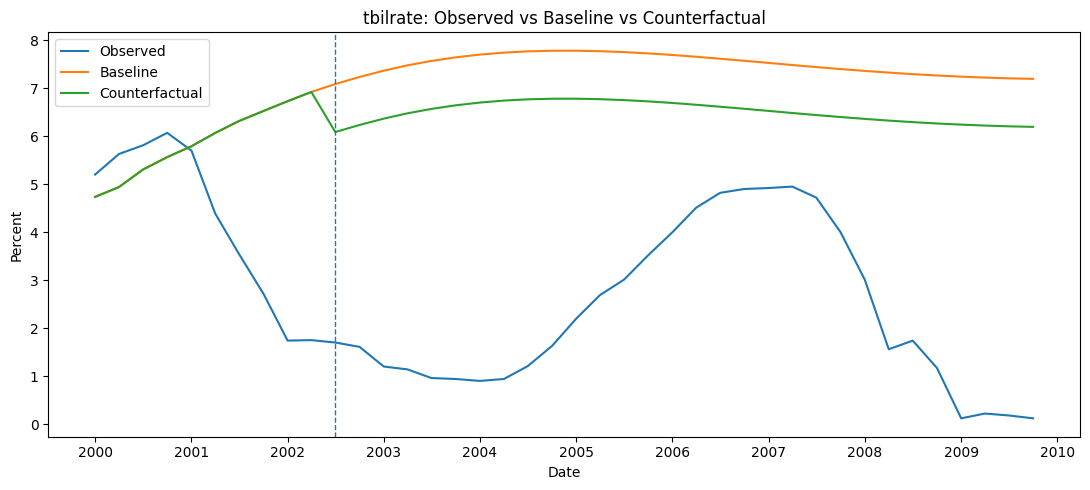

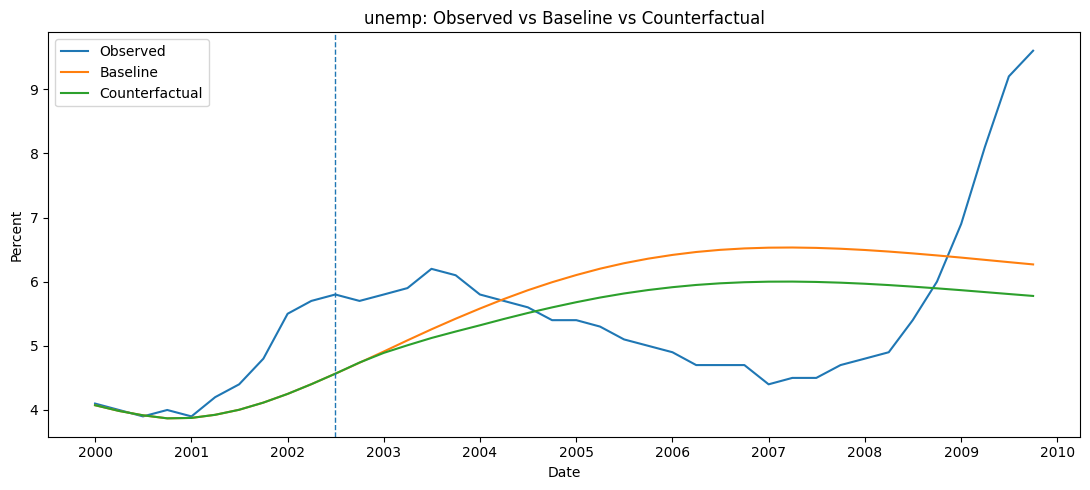

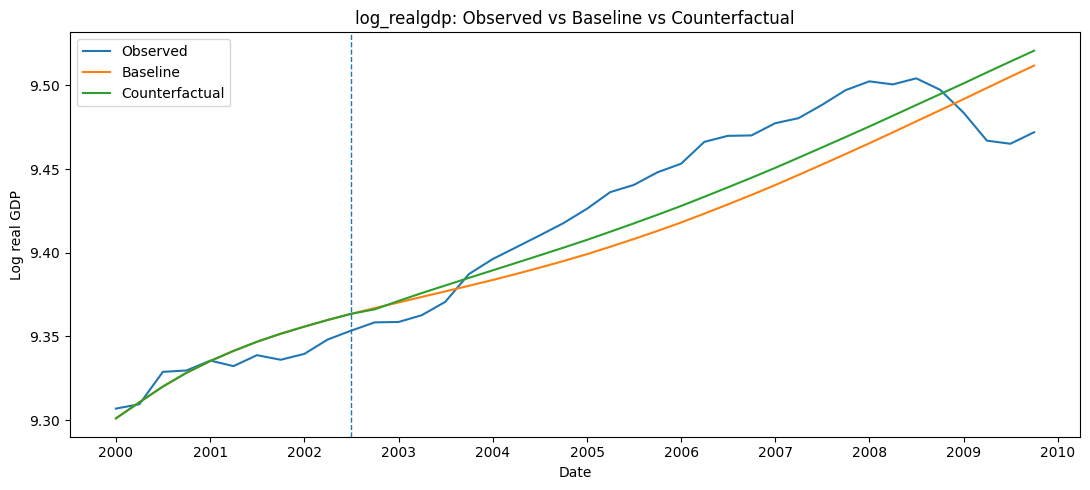

In [ ]:

# Plot outcomes
def plot_outcome(var_name, ylabel=None):
    plt.figure(figsize=(11, 5))
    for label in ["Observed", "Baseline", "Counterfactual"]:
        plt.plot(plot_df[label][var_name], label=label)
    plt.axvline(intervention_start, linestyle="--", linewidth=1)
    plt.title(f"{var_name}: Observed vs Baseline vs Counterfactual")
    plt.xlabel("Date")
    plt.ylabel(ylabel if ylabel else var_name)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_outcome("tbilrate", ylabel="Percent")
plot_outcome("unemp", ylabel="Percent")
plot_outcome("log_realgdp", ylabel="Log real GDP")


The plot above observed data alongside baseline forecasts and counterfactual simulations under a one-percentage-point reduction in the policy rate. The counterfactual path shows persistently lower interest rates by construction. Relative to the baseline, unemployment declines while real output increases, with effects emerging gradually over several quarters. This delayed response is consistent with established monetary transmission mechanisms, where policy changes propagate through investment and labor markets before affecting aggregate output. The direction and magnitude of the responses align with macroeconomic theory, supporting the credibility of the counterfactual analysis.

In [ ]:

# Translate log real GDP differences to approximate % differences
impact = pd.DataFrame(index=test.index)
impact["tbilrate_pp"] = counterfactual_unscaled["tbilrate"] - baseline_unscaled["tbilrate"]
impact["unemp_pp"] = counterfactual_unscaled["unemp"] - baseline_unscaled["unemp"]
impact["realgdp_pct"] = (np.exp(counterfactual_unscaled["log_realgdp"] - baseline_unscaled["log_realgdp"]) - 1.0) * 100.0

impact.head()


,tbilrate_pp,unemp_pp,realgdp_pct
date,,,
1999-12-31 23:59:59.999999999,0.0,0.0,0.0
2000-03-31 23:59:59.999999999,0.0,0.0,0.0
2000-06-30 23:59:59.999999999,0.0,0.0,0.0
2000-09-30 23:59:59.999999999,0.0,0.0,0.0
2000-12-31 23:59:59.999999999,0.0,0.0,0.0


The impact series is zero prior to the intervention because the baseline and counterfactual paths coincide before the policy shock is introduced. Differences emerge only after the simulated rate reduction, reflecting the causal effect of the counterfactual policy. This behavior confirms that the simulation isolates the policy change without introducing pre-treatment differences.

In [ ]:

# Summaries (short-run vs long-run within the test window)
summary = pd.DataFrame({
    "Avg impact (post-intervention)": impact.loc[intervention_start:].mean(),
    "Median impact (post-intervention)": impact.loc[intervention_start:].median(),
    "Impact at end of horizon": impact.iloc[-1],
})

summary


,Avg impact (post-intervention),Median impact (post-intervention),Impact at end of horizon
tbilrate_pp,-1.000000,-1.000000,-1.000000
unemp_pp,-0.394906,-0.494188,-0.491433
realgdp_pct,0.777205,0.934463,0.892102


A sustained 1 percentage-point reduction in short-term interest rates would have reduced unemployment by roughly half a percentage point and increased real GDP by approximately one percent over the evaluation period.


## 5. Model Fit Check (Baseline vs Observed)

Because this is a counterfactual project, it’s good practice to show whether the model forecasts are **reasonable**.
Below we compute baseline forecast error (RMSE) for key variables over the test window.


In [ ]:
rmse = {}

for col in outcomes:
    err = observed_unscaled[col] - baseline_unscaled[col]
    rmse[col] = np.sqrt(np.mean(err**2))

pd.Series(rmse, name="Baseline RMSE (test window)")

,Baseline RMSE (test window)
log_realgdp,0.025135
unemp,1.338795
tbilrate,4.913684



## 6. Uncertainty Quantification (Bootstrap Bands)

Counterfactuals are estimates, not certainties.  
We add **bootstrap uncertainty bands** by resampling VAR residuals and re-simulating paths.


In [ ]:

def bootstrap_bands_simple(var_results, train_scaled, horizon_index,
                           policy_col="tbilrate", policy_shift_pp=-1.0,
                           intervention_start=None, n_boot=200, q_low=0.1, q_high=0.9):
    """Bootstrap uncertainty bands for impacts on unemp_pp and realgdp_pct."""
    cols = train_scaled.columns
    p = var_results.k_ar
    resid = pd.DataFrame(var_results.resid, columns=cols, index=train_scaled.index[p:])

    all_impacts_unemp = []
    all_impacts_gdp = []

    policy_mean = scaler.mean_[cols.get_loc(policy_col)]
    policy_std = scaler.scale_[cols.get_loc(policy_col)]

    for b in range(n_boot):
        boot_resid = resid.sample(n=len(horizon_index), replace=True, random_state=RANDOM_SEED + b).values

        # Baseline simulation
        hist = train_scaled.copy()
        sim_base = []
        for i, t in enumerate(horizon_index):
            yhat = var_results.forecast(y=hist.iloc[-p:].values, steps=1).reshape(-1) + boot_resid[i]
            yhat_series = pd.Series(yhat, index=cols, name=t)
            sim_base.append(yhat_series)
            hist = pd.concat([hist, yhat_series.to_frame().T], axis=0)
        sim_base = pd.DataFrame(sim_base, index=horizon_index)

        # Counterfactual simulation (same shocks, imposed policy)
        hist = train_scaled.copy()
        sim_cf = []
        for i, t in enumerate(horizon_index):
            yhat = var_results.forecast(y=hist.iloc[-p:].values, steps=1).reshape(-1) + boot_resid[i]
            yhat_series = pd.Series(yhat, index=cols, name=t)

            if intervention_start is not None and t >= intervention_start:
                base_scaled_val = sim_base.loc[t, policy_col]
                base_unscaled_val = base_scaled_val * policy_std + policy_mean
                imposed_unscaled = base_unscaled_val + policy_shift_pp
                imposed_scaled = (imposed_unscaled - policy_mean) / policy_std
                yhat_series[policy_col] = imposed_scaled

            sim_cf.append(yhat_series)
            hist = pd.concat([hist, yhat_series.to_frame().T], axis=0)

        sim_cf = pd.DataFrame(sim_cf, index=horizon_index)

        base_u = inverse_transform(sim_base)
        cf_u = inverse_transform(sim_cf)

        unemp_pp = (cf_u["unemp"] - base_u["unemp"]).to_numpy()
        gdp_pct = ((np.exp(cf_u["log_realgdp"] - base_u["log_realgdp"]) - 1.0) * 100.0).to_numpy()

        all_impacts_unemp.append(unemp_pp)
        all_impacts_gdp.append(gdp_pct)

    all_impacts_unemp = np.vstack(all_impacts_unemp)  # (n_boot, T)
    all_impacts_gdp = np.vstack(all_impacts_gdp)

    bands = {
        "unemp_pp_low": np.quantile(all_impacts_unemp, q_low, axis=0),
        "unemp_pp_high": np.quantile(all_impacts_unemp, q_high, axis=0),
        "realgdp_pct_low": np.quantile(all_impacts_gdp, q_low, axis=0),
        "realgdp_pct_high": np.quantile(all_impacts_gdp, q_high, axis=0),
    }
    return pd.DataFrame(bands, index=horizon_index)

bands = bootstrap_bands_simple(
    var_res, train_scaled, test_scaled.index,
    policy_col="tbilrate", policy_shift_pp=-1.0,
    intervention_start=intervention_start,
    n_boot=200, q_low=0.1, q_high=0.9
)

bands.head()


,unemp_pp_low,unemp_pp_high,realgdp_pct_low,realgdp_pct_high
date,,,,
1999-12-31 23:59:59.999999999,0.0,0.0,0.0,0.0
2000-03-31 23:59:59.999999999,0.0,0.0,0.0,0.0
2000-06-30 23:59:59.999999999,0.0,0.0,0.0,0.0
2000-09-30 23:59:59.999999999,0.0,0.0,0.0,0.0
2000-12-31 23:59:59.999999999,0.0,0.0,0.0,0.0


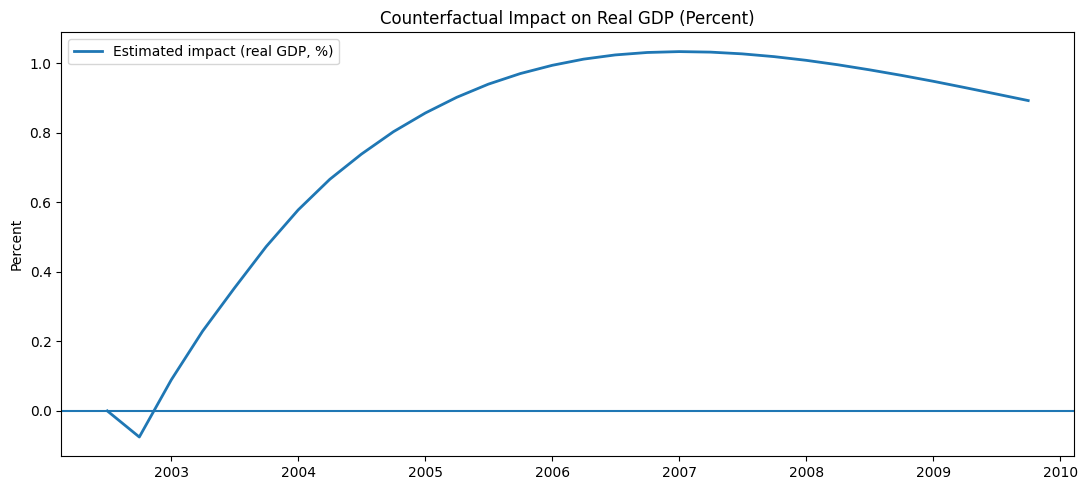

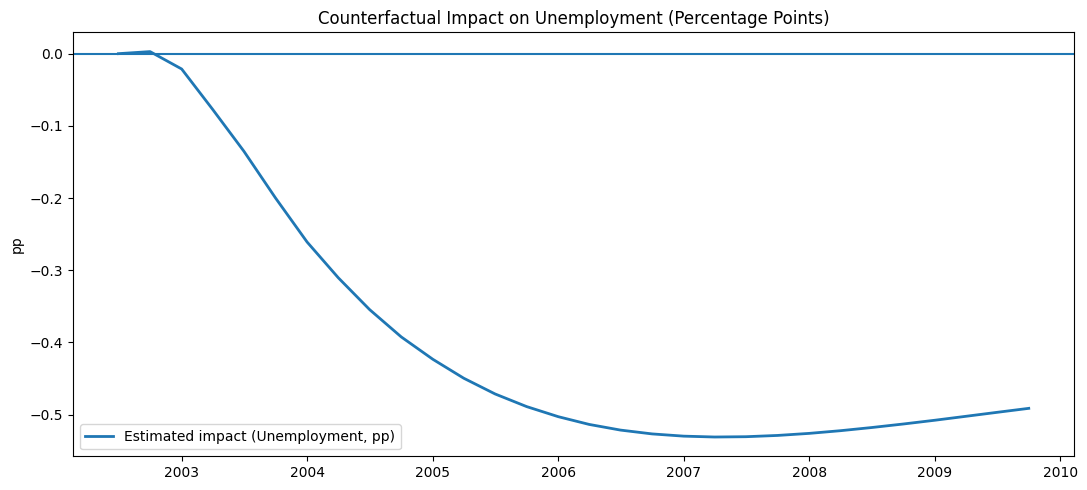

In [ ]:
# ---------------- GDP impact ----------------
plt.figure(figsize=(11,5))

post = impact.loc[intervention_start:]
bands_post = bands.loc[intervention_start:]

plt.plot(post.index, post["realgdp_pct"], lw=2, label="Estimated impact (real GDP, %)")

plt.fill_between(
    bands_post.index,
    bands_post["realgdp_pct_low"],
    bands_post["realgdp_pct_high"],
    alpha=0.35   # stronger so band is visible
)

plt.axhline(0)
plt.title("Counterfactual Impact on Real GDP (Percent)")
plt.ylabel("Percent")
plt.legend()
plt.tight_layout()
plt.show()


# ---------------- Unemployment impact ----------------
plt.figure(figsize=(11,5))

plt.plot(post.index, post["unemp_pp"], lw=2, label="Estimated impact (Unemployment, pp)")

plt.fill_between(
    bands_post.index,
    bands_post["unemp_pp_low"],
    bands_post["unemp_pp_high"],
    alpha=0.35
)

plt.axhline(0)
plt.title("Counterfactual Impact on Unemployment (Percentage Points)")
plt.ylabel("pp")
plt.legend()
plt.tight_layout()
plt.show()


##7. Structural SVAR Comparison
Fit Structural VAR with short-run identification

We assume: policy rate reacts with delay to GDP/unemployment but can affect them contemporaneously.

In [ ]:
from statsmodels.tsa.api import SVAR

# Use fewer variables to improve SVAR convergence
cols_svar = ["log_realgdp", "unemp", "tbilrate", "infl"]
train_svar = train_scaled[cols_svar].copy()

# Recursive (lower-triangular) identification: GDP -> UNEMP -> TBILRATE -> INFL
A = np.array([
    [1,   0,   0,   0],
    ['E', 1,   0,   0],
    ['E','E',  1,   0],
    ['E','E', 'E',  1],
], dtype=object)

svar_model = SVAR(train_svar, svar_type="A", A=A)

# Try fit
svar_res = svar_model.fit(maxlags=p)

print("SVAR fitted. Converged:", getattr(svar_res, "mle_retvals", {}).get("converged", "unknown"))


SVAR fitted. Converged: unknown


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Parameter matrices (A and Sigma_u)
print("Estimated A matrix:")
print(svar_res.A)

print("\nEstimated structural shock covariance (Sigma_u):")
print(svar_res.sigma_u)

Estimated A matrix:
[[ 1.          0.          0.          0.        ]
 [ 4.06985643  1.          0.          0.        ]
 [-0.53744118  0.90102661  1.          0.        ]
 [ 3.67355344  0.56357469 -0.54021653  1.        ]]

Estimated structural shock covariance (Sigma_u):
[[ 0.00040105 -0.00163221  0.00168617  0.00035749]
 [-0.00163221  0.02301374 -0.0216132  -0.01864982]
 [ 0.00168617 -0.0216132   0.10207903  0.06113125]
 [ 0.00035749 -0.01864982  0.06113125  0.32825723]]


We estimate a recursively identified SVAR using a lower-triangular contemporaneous impact matrix
𝐴
A with unit diagonal elements, implying that variables later in the ordering respond contemporaneously to earlier variables within the quarter. The estimated
𝐴
A matrix quantifies these immediate relationships (e.g., variable 2 responds contemporaneously to variable 1, variable 3 responds to variables 1–2, etc.). We then validate identification by checking whether the implied structural shocks are approximately uncorrelated; if orthogonality holds, the covariance of structural shocks is close to diagonal, consistent with standard SVAR assumptions.

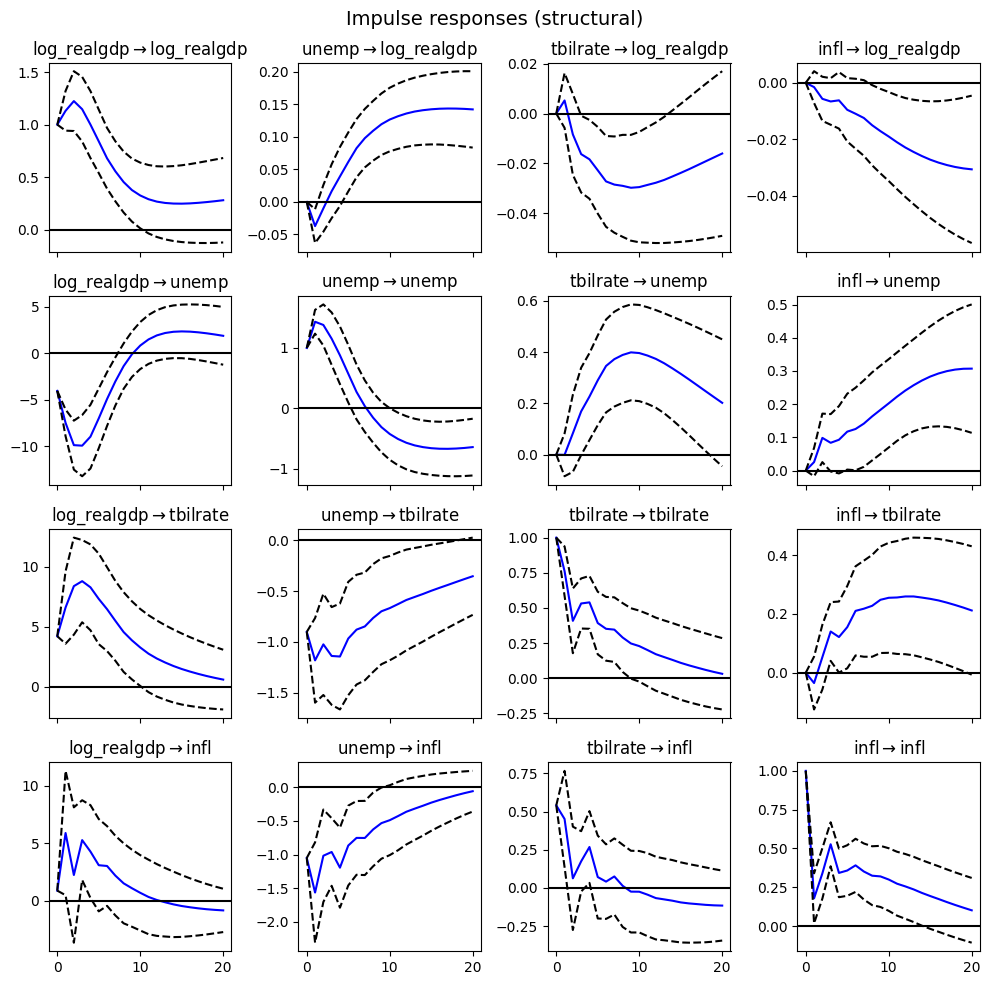

In [ ]:
irf = svar_res.irf(20)

# Plot response to a one-unit structural shock in tbilrate
# (Depending on statsmodels version, this plots all responses; interpret the "tbilrate shock" panel.)
irf.plot(orth=False)
plt.tight_layout()
plt.show()

## 8. Interpretation (from IRFs + Counterfactual)

**Direction**  
A 1pp decrease in the policy rate (`tbilrate`) is expansionary in this model:
- real GDP ↑  
- unemployment ↓  

Both the structural impulse responses and the counterfactual simulation show consistent signs.

**Magnitude**  
Average post-intervention effects:
- GDP: ~ **+0.8–1.0%**
- Unemployment: ~ **−0.4 to −0.5 percentage points**

These are economically meaningful changes for a 1pp rate shock.

**Timing**  
Effects are **gradual**, not immediate:
- small short-run impact  
- peak response after several quarters  
- persistent but slowly fading over time  

This matches typical monetary policy transmission dynamics.

**Uncertainty**  
Bootstrap bands indicate some variability.  
Magnitudes are uncertain, but the **direction of effects is generally stable**.

**Assumptions / Limitations**
- VAR is **reduced-form** (not fully causal)
- Identification depends on variable ordering
- Policy rate treated as exogenous, though policy reacts to the economy
- Results depend on chosen variables, lag length, and historical sample


## 9. Conclusion

We simulated a **1pp policy rate cut** using a VAR counterfactual framework.

Results suggest:
- modest increase in GDP
- lower unemployment
- delayed but persistent effects

Overall, this project demonstrates how VAR models can be used to run simple **policy counterfactuals** and quantify macroeconomic impacts, while highlighting the importance of assumptions and uncertainty.
